In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spst

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialization and Data Loading

In [12]:
# Loading Data

data=pd.read_csv("/content/drive/MyDrive/DDDM_Project/Data/final_dataset.csv")
df =data.copy().drop(columns=["Unnamed: 0"])

# cleaning

df["Month"] = pd.to_datetime(df["Month"])

# Sort by time then ETF (important for sanity and reproducibility)
df = df.sort_values(["Month", "ETF"]).reset_index(drop=True)

# Ensure tag columns are integers (0/1)
TAG_COLS = [
    "is_equity",
    "is_international",
    "is_gov",
    "is_credit",
    "is_macro"
]

for c in TAG_COLS:
    df[c] = df[c].astype(int)

df.head()

,Month,Open,Close,Growth,ETF,rf_month,outperformed,excess_return,months_outperforming,TB3MS_lag1,...,inflation_yoy_lag1,inflation_shock_lag1,yield_slope_lag1,credit_spread_lag1,VIXCLS_lag1,is_equity,is_international,is_gov,is_credit,is_macro
0,1993-01-31,43.96875,43.93750,-0.000711,SPY,0.002466,0,-0.003177,0,3.22,...,0.029667,-0.001032,3.550000,2.040000,12.191364,1,0,0,0,0
1,1993-02-28,43.96875,44.40625,0.009950,SPY,0.002409,1,0.007541,0,3.00,...,0.032538,0.000842,3.600000,2.070000,12.409000,1,0,0,0,0
2,1993-03-31,44.56250,45.18750,0.014025,SPY,0.002426,1,0.011600,1,2.93,...,0.032468,-0.000566,3.328947,2.131053,13.721579,1,0,0,0,0
3,1993-04-30,45.25000,44.03125,-0.026934,SPY,0.002361,0,-0.029294,2,2.95,...,0.030194,-0.001085,3.025217,2.174783,13.606087,1,0,0,0,0
4,1993-05-31,44.09375,45.21875,0.025514,SPY,0.002434,1,0.023080,0,2.87,...,0.031564,0.000896,3.099524,2.170476,12.840952,1,0,0,0,0


In [13]:
# validate data

def validate_panel(df):
    # Required columns
    required_cols = [
        "Month", "ETF",
        "excess_return", "outperformed", "rf_month"
    ] + TAG_COLS

    missing = set(required_cols) - set(df.columns)
    assert len(missing) == 0, f"Missing columns: {missing}"

    # One row per (Month, ETF)
    dupes = df.duplicated(subset=["Month", "ETF"])
    assert not dupes.any(), "Duplicate (Month, ETF) rows detected"

    # Month sorted
    assert df["Month"].is_monotonic_increasing, "Month not sorted"

    # No NaNs in required fields
    nan_cols = df[required_cols].columns[df[required_cols].isna().any()]
    assert len(nan_cols) == 0, f"NaNs found in columns: {list(nan_cols)}"

    # Tags must be 0/1
    for c in TAG_COLS:
        bad = ~df[c].isin([0, 1])
        assert not bad.any(), f"Invalid values in tag column {c}"

    # outperformed must be binary
    assert df["outperformed"].isin([0, 1]).all(), "outperformed not binary"

    # all ETFs must have a tag
    tag_sums = (
        df.groupby("ETF")[TAG_COLS]
          .sum()
          .sum(axis=1)
    )

    no_tag_etfs = tag_sums[tag_sums == 0].index.tolist()

    assert len(no_tag_etfs) == 0, (
        f"ETFs with no active tags detected: {no_tag_etfs}"
    )

    print("✅ Panel validation passed")

In [14]:
validate_panel(df)

✅ Panel validation passed


In [15]:
# Configuring Constants

# (TAG_COLS, MACRO_COLS)
# (ESS_B, alpha0, beta0, eps_B)
# (nu, var_window, mc_N, eps_s, tau0)

TAG_COLS = [
    "is_equity",
    "is_international",
    "is_gov",
    "is_credit",
    "is_macro",
]

MACRO_COLS = [
    "TB3MS_lag1",
    "dTB3MS_lag1",
    "UNRATE_lag1",
    "inflation_yoy_lag1",
    "inflation_shock_lag1",
    "yield_slope_lag1",
    "credit_spread_lag1",
    "VIXCLS_lag1",
]

MONTH_COL = "Month"
ETF_COL   = "ETF"

GROWTH_COL = "Growth"         # actual ETF return for accounting
RET_COL   = "excess_return"   # continuous excess return x_{i,t}
BIN_COL   = "outperformed"    # binary 1{x_{i,t} > 0}
RF_COL    = "rf_month"        # monthly risk-free rate

# bernoulli params
ESS_B = 10
alpha0, beta0 = 2.0, 2.0
epsilon_B = 1e-8

# student-t params
nu = 5
vol_window = 12
mc_N = 2000
eps_s = 0.0005
tau0 = 0.05

# rng for reproducability
seed = 123
rng = np.random.default_rng(seed)

## Results tracking

In [16]:
WEALTH_LOG_COLS = [
    "Month_hold",      # holding month (t+1)
    "port_ret",        # realized portfolio return in Month_hold
    "wealth",          # wealth after applying port_ret
    "w_cash",          # cash weight held in Month_hold
    "W_etf",           # total ETF exposure held in Month_hold (1 - w_cash)
    "mean_score",      # mean of scores over available ETFs at decision month t
    "turnover",        # 0.5 * sum_j |w_j(t+1) - w_j(t)| (including CASH)
    "n_bet",           # number of ETFs with weight > 0 in Month_hold
    "top5_share",      # sum of top-5 ETF weights in Month_hold (ETFs only)
]

WEIGHTS_LOG_COLS = [
    "Month_hold",      # holding month (t+1)
    "ETF",             # ETF ticker or "CASH"
    "weight",          # portfolio weight held in Month_hold
]

SCORES_LOG_COLS = [
    "Month_decide",    # decision month (t)
    "ETF",             # ETF ticker
    "score",           # nonnegative score produced at decision month t
]


## Portfolio Policy (shared)

In [17]:
def scores_to_weights(scores, k, eps=1e-16):
    """
    Convert nonnegative ETF scores at decision month t into portfolio weights to HOLD at month t+1.

    Inputs
    ------
    scores : dict[str -> float]
        Nonnegative scores s_{i,t} for ETFs available at decision month t.
    k : float
        Exposure strength parameter.
    eps : float
        Tiny constant to avoid division-by-zero in normalization.

    Outputs
    -------
    w_etf : dict[str -> float]
        ETF weights for holding month (t+1). Sums to W_etf.
    w_cash : float
        Cash weight for holding month (t+1). Equals 1 - W_etf.
    diag : dict
        Diagnostics: mean_score (S_t), W_etf, n_pos_scores, top5_share.
    """
    if scores is None or len(scores) == 0:
        # No arms available: full cash
        return {}, 1.0, {"mean_score": 0.0, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    # Ensure nonnegative floats (defensive)
    s = {etf: float(max(0.0, v)) for etf, v in scores.items()}
    vals = np.fromiter(s.values(), dtype=float)

    mean_score = float(vals.mean()) if len(vals) else 0.0
    n_pos = int((vals > 0).sum())

    # If no signal, go full cash
    if n_pos == 0 or mean_score <= 0.0:
        return {}, 1.0, {"mean_score": mean_score, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    # Total ETF exposure W_etf from mean score and k:
    # W_etf = (k * mean_score) / (1 + k * mean_score)
    # (Always in (0,1), increases with k and mean_score)
    W_etf = (k * mean_score) / (1.0 + k * mean_score) if k > 0 else 0.0
    W_etf = float(np.clip(W_etf, 0.0, 1.0))
    w_cash = 1.0 - W_etf

    # Within-ETF proportions: linear normalization over positive scores
    pos_sum = float(vals[vals > 0].sum())
    if pos_sum <= eps:
        # numerical fallback -> full cash
        return {}, 1.0, {"mean_score": mean_score, "W_etf": 0.0, "n_pos_scores": 0, "top5_share": 0.0}

    w_etf = {etf: W_etf * (v / pos_sum) for etf, v in s.items() if v > 0}

    # Concentration metric: top-5 share among ETF weights
    if len(w_etf) == 0:
        top5_share = 0.0
    else:
        top5_share = float(np.sum(sorted(w_etf.values(), reverse=True)[:5]))

    diag = {
        "mean_score": mean_score,
        "W_etf": W_etf,
        "n_pos_scores": len(w_etf),
        "top5_share": top5_share,
    }
    return w_etf, w_cash, diag

In [18]:
def turnover(prev_weights_full, curr_weights_full):
    """
    0.5 * sum_j |w_j(new) - w_j(old)| over union of keys.
    Both dicts should include CASH explicitly.
    """
    keys = set(prev_weights_full) | set(curr_weights_full)
    return 0.5 * sum(abs(curr_weights_full.get(k, 0.0) - prev_weights_full.get(k, 0.0)) for k in keys)

## Accounting

In [19]:
def portfolio_return_for_month(df_hold, w_etf, w_cash):
    """
    Realized TOTAL portfolio return in a holding month (t+1):

        r_p = sum_i w_i * Growth_{i,t+1} + w_cash * rf_{t+1}

    Uses:
    - Growth for ETF returns (actual traded returns)
    - rf_month for cash return
    """

    # rf is unique per month
    rf_vals = df_hold[RF_COL].dropna().unique()
    assert len(rf_vals) == 1, f"Expected exactly one rf value, got {rf_vals}"
    rf = float(rf_vals[0])

    # realized ETF returns (Growth)
    realized_growth = dict(
        zip(df_hold[ETF_COL].values, df_hold[GROWTH_COL].values)
    )

    etf_ret = 0.0
    for etf, w in w_etf.items():
        etf_ret += float(w) * float(realized_growth.get(etf, 0.0))

    cash_ret = float(w_cash) * rf
    return etf_ret + cash_ret

## Bernoulli Beliefs and Scoring

In [28]:
# Birth prior beliefs (global and tag-specific)

def init_belief_state_bernoulli():
    """
    belief_state stores:
      - global alpha/beta counts (for overall Pr(outperform))
      - per-tag alpha/beta counts (for Pr(outperform | tag=1))
    We maintain counts via Beta posterior parameters.
    """
    belief_state = {
        "global_alpha": float(alpha0),
        "global_beta": float(beta0),
        "tag_alpha": {tag: float(alpha0) for tag in TAG_COLS},
        "tag_beta":  {tag: float(beta0)  for tag in TAG_COLS},
    }
    return belief_state


def update_beliefs_bernoulli(belief_state, df_t):
    """
    Full-information monthly update:
    For every ETF observed in month t, update:
      - global Beta posterior using y_it
      - each tag-specific Beta posterior for tags that ETF has (tag==1) using y_it
    """
    y = df_t[BIN_COL].astype(int).values
    tags_mat = df_t[TAG_COLS].astype(int).values  # shape (n, n_tags)

    # global update
    s = int(y.sum())
    f = int(len(y) - s)
    belief_state["global_alpha"] += s
    belief_state["global_beta"]  += f

    # tag-conditional updates
    # For each tag k, update using y for rows where tag==1
    for j, tag in enumerate(TAG_COLS):
        mask = tags_mat[:, j] == 1
        if mask.any():
            y_k = y[mask]
            s_k = int(y_k.sum())
            f_k = int(len(y_k) - s_k)
            belief_state["tag_alpha"][tag] += s_k
            belief_state["tag_beta"][tag]  += f_k


def bernoulli_birth_prior(belief_state, tags_row, ESS_B=ESS_B):
    """
    Construct ETF-level Beta prior (alpha_i, beta_i) at birth using tag-informed logit offsets.

    Steps:
    1) Compute global mean p_g
    2) For each tag, compute p_tag and delta_tag = logit(p_tag) - logit(p_g)
    3) For ETF i, theta_i = logit(p_g) + sum_{tag present} delta_tag
    4) Convert theta_i -> p_i via logistic
    5) Map p_i and ESS_B into Beta(alpha_i, beta_i):
         alpha_i = p_i * ESS_B
         beta_i  = (1 - p_i) * ESS_B
    """
    def logit(p):
        p = np.clip(p, 1e-12, 1 - 1e-12)
        return np.log(p / (1 - p))

    def logistic(z):
        return 1.0 / (1.0 + np.exp(-z))

    # global posterior mean
    a_g = belief_state["global_alpha"]
    b_g = belief_state["global_beta"]
    p_g = a_g / (a_g + b_g)
    g = logit(p_g)

    # build deltas for tags
    deltas = {}
    for tag in TAG_COLS:
        a_k = belief_state["tag_alpha"][tag]
        b_k = belief_state["tag_beta"][tag]
        p_k = a_k / (a_k + b_k)
        deltas[tag] = logit(p_k) - g

    # apply deltas for tags present on this ETF
    theta = g
    for tag in TAG_COLS:
        if int(tags_row[tag]) == 1:
            theta += deltas[tag]

    p_i = float(logistic(theta))
    alpha_i = float(p_i * ESS_B)
    beta_i  = float((1.0 - p_i) * ESS_B)

    return alpha_i, beta_i

In [31]:
# ETF specific state updates

def init_states_bernoulli():
    """
    Per-ETF state: Beta posterior parameters (alpha_i, beta_i).
    Stored as:
      states[ETF] = {"alpha": ..., "beta": ...}
    """
    return {}

def ensure_states_bernoulli(states, belief_state, df_t):
    """
    Initialize state for any ETF that appears in df_t but is not yet in states,
    using the tag-informed birth prior.
    """
    # We only need one tags_row per ETF, so drop duplicates on ETF
    first_rows = df_t.drop_duplicates(subset=[ETF_COL])

    for _, row in first_rows.iterrows():
        etf = row[ETF_COL]
        if etf not in states:
            a_i, b_i = bernoulli_birth_prior(belief_state, row, ESS_B=ESS_B)
            states[etf] = {"alpha": float(a_i), "beta": float(b_i)}

def update_states_bernoulli(states, df_t):
    """
    Full-information posterior update for all ETFs in df_t using outperformed (0/1).
    """
    for _, row in df_t.iterrows():
        etf = row[ETF_COL]
        y = int(row[BIN_COL])
        # states should exist (ensure_states_bernoulli called first)
        states[etf]["alpha"] += y
        states[etf]["beta"]  += (1 - y)

def scores_bernoulli(states, A_t, p1, epsilon_B=epsilon_B):
    """
    Compute nonnegative scores for ETFs in A_t using:
      P_it = alpha / (alpha + beta)
      s_it = max(0, P_it - p1)
    epsilon_B is a tiny floor for numerical stability (mostly irrelevant here).
    """
    scores = {}
    for etf in A_t:
        st = states.get(etf, None)
        if st is None:
            scores[etf] = 0.0
            continue
        a = st["alpha"]
        b = st["beta"]
        p_hat = a / (a + b)
        s = max(0.0, float(p_hat - p1))
        if s > 0:
            s = max(s, float(epsilon_B))
        scores[etf] = s
    return scores

## Student-t Beliefs and Scoring

In [79]:
# STUDENT-t: GLOBAL VOLATILITY s_t (trailing)


def global_volatility(df, month_t, vol_window=vol_window):
    """
    Compute global volatility estimate s_t using trailing months strictly before month_t.
    Uses cross-sectional ETF excess returns (RET_COL) pooled.
    """
    months = sorted(df[MONTH_COL].unique())
    t_idx = months.index(month_t)

    # Need at least vol_window months before t
    if t_idx < vol_window:
        return np.nan

    trailing_months = months[t_idx - vol_window : t_idx]  # strictly before t
    x = df.loc[df[MONTH_COL].isin(trailing_months), RET_COL].astype(float).values

    # Use sample std; floor to avoid zeros
    s = float(np.nanstd(x, ddof=1))
    return max(s, 1e-8)

In [80]:
# STUDENT-t: TAG-BELIEF LAYER (birth mean only)

def init_belief_state_studentt():
    """
    Track global + per-tag mean of excess_return for birth prior mean initialization.
    Stores counts and sums.
    """
    return {
        "global_n": 0,
        "global_sum": 0.0,
        "tag_n": {tag: 0 for tag in TAG_COLS},
        "tag_sum": {tag: 0.0 for tag in TAG_COLS},
    }

def update_beliefs_studentt(belief_state, df_t):
    """
    Update global + per-tag running sums for excess_return using full info in df_t.
    """
    x = df_t[RET_COL].astype(float).values
    belief_state["global_n"] += int(len(x))
    belief_state["global_sum"] += float(np.nansum(x))

    tags_mat = df_t[TAG_COLS].astype(int).values
    for j, tag in enumerate(TAG_COLS):
        mask = tags_mat[:, j] == 1
        if mask.any():
            x_k = x[mask]
            belief_state["tag_n"][tag] += int(len(x_k))
            belief_state["tag_sum"][tag] += float(np.nansum(x_k))

def studentt_birth_prior_mean(belief_state, tags_row):
    """
    Mean-only birth prior using additive tag deviations:
      m_i = m_g + sum_{tag present} (m_tag - m_g)
    with safe fallbacks when counts are small.
    """
    n_g = belief_state["global_n"]
    m_g = belief_state["global_sum"] / n_g if n_g > 0 else 0.0

    m = float(m_g)
    for tag in TAG_COLS:
        if int(tags_row[tag]) == 1:
            n_k = belief_state["tag_n"][tag]
            m_k = belief_state["tag_sum"][tag] / n_k if n_k > 0 else m_g
            m += float(m_k - m_g)
    return float(m)

In [81]:
# STUDENT-t: ETF STATES (posterior over mean)


def init_states_studentt():
    """
    Per-ETF state stores posterior over mean mu_i:
      states[ETF] = {"m": posterior_mean, "v": posterior_var}
    """
    return {}

def ensure_states_studentt(states, belief_state, df_t):
    """
    Initialize any new ETF with prior mean from tags and prior var tau0^2.
    """
    first_rows = df_t.drop_duplicates(subset=[ETF_COL])
    for _, row in first_rows.iterrows():
        etf = row[ETF_COL]
        if etf not in states:
            m0 = studentt_birth_prior_mean(belief_state, row)
            states[etf] = {"m": float(m0), "v": float(tau0**2)}

def update_states_studentt(states, df_t, s_t):
    """
    Update posterior over mu_i given observation x_it and noise variance s_t^2.
    """
    if not np.isfinite(s_t) or s_t <= 0:
        return  # skip updates if s_t undefined early sample

    obs_var = float(s_t**2)

    for _, row in df_t.iterrows():
        etf = row[ETF_COL]
        x = float(row[RET_COL])

        m_prev = states[etf]["m"]
        v_prev = states[etf]["v"]

        # Normal-Normal update
        v_post = 1.0 / (1.0 / v_prev + 1.0 / obs_var)
        m_post = v_post * (m_prev / v_prev + x / obs_var)

        states[etf]["m"] = float(m_post)
        states[etf]["v"] = float(v_post)

In [84]:
# STUDENT-t: SCORING (expected positive payoff)

def scores_studentt(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    Explicit Student-t score:
      score = Pr(X > 0) * E[X | X > 0]
    where X = mu_i + s_t * T_nu
    """
    scores = {}
    if (not np.isfinite(s_t)) or s_t <= 0:
        return {etf: 0.0 for etf in A_t}

    t_draws = spst.t.rvs(df=nu, size=mc_N, random_state=rng).astype(float)

    for etf in A_t:
        st = states.get(etf, None)
        if st is None:
            scores[etf] = 0.0
            continue

        mu = float(st["m"])
        X = mu + s_t * t_draws

        pos = X > 0
        if not pos.any():
            scores[etf] = 0.0
            continue

        p_pos = float(pos.mean())
        mean_pos = float(X[pos].mean())

        score = p_pos * mean_pos
        scores[etf] = max(score, eps_s) if score > 0 else 0.0

    return scores

## Run Bernoulli Simulation

In [41]:
# bernoulli simulation

def run_policy_simulation_bernoulli(df, p1, k, initial_wealth=1000.0):
    """
    Historical policy simulation using Bernoulli bandit scores.

    Decision month t:
      - update tag-beliefs using df_t (global + per-tag)
      - initialize new ETFs using tag-informed birth priors
      - update ETF posteriors using outperformed_{i,t}
      - compute scores s_{i,t} = max(0, P_{i,t} - p1)

    Holding month t+1:
      - convert scores -> weights via scores_to_weights(k)
      - apply realized returns using Growth + rf_month
      - log wealth, weights, diagnostics
    """

    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    # Initialize belief layer + ETF states once
    belief_state = init_belief_state_bernoulli()
    states = init_states_bernoulli()

    # Start fully in cash
    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]

        A_t = df_t[ETF_COL].unique().tolist()


        # LEARNING AT DECISION MONTH t
        update_beliefs_bernoulli(belief_state, df_t)                 # belief layer (birth priors only)
        ensure_states_bernoulli(states, belief_state, df_t)          # init new ETFs
        update_states_bernoulli(states, df_t)                        # ETF posterior updates


        # SCORING AT DECISION MONTH t
        scores = scores_bernoulli(states, A_t, p1=p1)

        # Log scores (decision month)
        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        # POLICY: weights to HOLD at t+1
        w_etf, w_cash, diag = scores_to_weights(scores, k)

        # Log weights (holding month)
        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        # APPLY RETURNS IN HOLD MONTH
        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth = wealth * (1.0 + port_ret)

        # Turnover (include CASH)
        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    wealth_df = pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS)
    weights_df = pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS)
    scores_df = pd.DataFrame(scores_log, columns=SCORES_LOG_COLS)

    return {"wealth": wealth_df, "weights": weights_df, "scores": scores_df}


## Run experiment with grid of params

In [51]:
# Run a grid of hyperparameters

def summarize_run(res):
    """
    res: dict with keys {"wealth","weights","scores"} from run_policy_simulation_bernoulli
    Returns: dict of summary metrics
    """
    wdf = res["wealth"]
    if len(wdf) == 0:
        return {
            "final_wealth": np.nan,
            "mean_W_etf": np.nan,
            "mean_turnover": np.nan
        }

    final_wealth = float(wdf["wealth"].iloc[-1])
    mean_W_etf = float(wdf["W_etf"].mean())
    mean_turnover = float(wdf["turnover"].mean())

    return {
        "final_wealth": final_wealth,
        "mean_W_etf": mean_W_etf,
        "mean_turnover": mean_turnover
    }


def run_grid_bernoulli(df, p1_grid, k_grid, initial_wealth=1000.0, verbose=True):
    """
    Runs Bernoulli policy simulation over (p1, k) grid.

    Returns
    -------
    results_dict : dict
        keys: (p1, k) tuples
        values: result dicts from run_policy_simulation_bernoulli

    summary_df : DataFrame
        columns: p1, k, final_wealth, mean_W_etf, mean_turnover
    """
    results_dict = {}
    summary_rows = []

    total = len(p1_grid) * len(k_grid)
    ctr = 0

    for p1 in p1_grid:
        for k in k_grid:
            ctr += 1
            if verbose:
                print(f"[{ctr}/{total}] running p1={p1}, k={k}")

            res = run_policy_simulation_bernoulli(df, p1=p1, k=k, initial_wealth=initial_wealth)
            results_dict[(p1, k)] = res

            summ = summarize_run(res)
            summary_rows.append({
                "p1": float(p1),
                "k": float(k),
                **summ
            })

    summary_df = pd.DataFrame(summary_rows).sort_values(["p1", "k"]).reset_index(drop=True)
    return results_dict, summary_df


def pivot_summary_table(summary_df, value_col):
    """
    Convenience: pivot summary_df into a p1 x k table for a single metric.
    """
    return summary_df.pivot(index="p1", columns="k", values=value_col).sort_index()

Bernoulli Hyperparameter Exploration

In [52]:
split_date = pd.Timestamp("2014-12-31")

df_train = df[df[MONTH_COL] <= split_date].copy()
df_test  = df[df[MONTH_COL] >  split_date].copy()

print("Train months:", df_train[MONTH_COL].min(), "→", df_train[MONTH_COL].max())
print("Test  months:", df_test[MONTH_COL].min(),  "→", df_test[MONTH_COL].max())

Train months: 1993-01-31 00:00:00 → 2014-12-31 00:00:00
Test  months: 2015-01-31 00:00:00 → 2022-08-31 00:00:00


In [53]:
p1_grid = [0.52, 0.55, 0.6, 0.65, 0.70]
k_grid  = [0, 5, 10, 20, 40, 80, 160, 320, 640]

In [54]:
results_train, summary_train = run_grid_bernoulli(
    df_train,
    p1_grid=p1_grid,
    k_grid=k_grid,
    initial_wealth=1000.0,
    verbose=True
)

summary_train

[1/45] running p1=0.52, k=0
[2/45] running p1=0.52, k=5
[3/45] running p1=0.52, k=10
[4/45] running p1=0.52, k=20
[5/45] running p1=0.52, k=40
[6/45] running p1=0.52, k=80
[7/45] running p1=0.52, k=160
[8/45] running p1=0.52, k=320
[9/45] running p1=0.52, k=640
[10/45] running p1=0.55, k=0
[11/45] running p1=0.55, k=5
[12/45] running p1=0.55, k=10
[13/45] running p1=0.55, k=20
[14/45] running p1=0.55, k=40
[15/45] running p1=0.55, k=80
[16/45] running p1=0.55, k=160
[17/45] running p1=0.55, k=320
[18/45] running p1=0.55, k=640
[19/45] running p1=0.6, k=0
[20/45] running p1=0.6, k=5
[21/45] running p1=0.6, k=10
[22/45] running p1=0.6, k=20
[23/45] running p1=0.6, k=40
[24/45] running p1=0.6, k=80
[25/45] running p1=0.6, k=160
[26/45] running p1=0.6, k=320
[27/45] running p1=0.6, k=640
[28/45] running p1=0.65, k=0
[29/45] running p1=0.65, k=5
[30/45] running p1=0.65, k=10
[31/45] running p1=0.65, k=20
[32/45] running p1=0.65, k=40
[33/45] running p1=0.65, k=80
[34/45] running p1=0.65, k=

,p1,k,final_wealth,mean_W_etf,mean_turnover
0,0.52,0.0,1786.185888,0.000000,0.000000
1,0.52,5.0,1825.172418,0.129232,0.025026
2,0.52,10.0,1858.858788,0.218039,0.039818
3,0.52,20.0,1911.031297,0.336247,0.057135
4,0.52,40.0,1980.168400,0.469315,0.074184
5,0.52,80.0,2062.837909,0.596037,0.088485
6,0.52,160.0,2159.855784,0.700042,0.098202
7,0.52,320.0,2270.511548,0.775486,0.103435
8,0.52,640.0,2382.297935,0.824913,0.105459
9,0.55,0.0,1786.185888,0.000000,0.000000


In [56]:
final_wealth_tbl = pivot_summary_table(summary_train, "final_wealth")
mean_W_tbl       = pivot_summary_table(summary_train, "mean_W_etf")
mean_turn_tbl    = pivot_summary_table(summary_train, "mean_turnover")

final_wealth_tbl, mean_W_tbl, mean_turn_tbl

(k           0.0          5.0          10.0         20.0         40.0   \
 p1                                                                      
 0.52  1786.185888  1825.172418  1858.858788  1911.031297  1980.168400   
 0.55  1786.185888  1783.828769  1788.753401  1804.793719  1837.104723   
 0.60  1786.185888  1758.431015  1737.558454  1708.530043  1676.396026   
 0.65  1786.185888  1775.325948  1765.756321  1749.839826  1727.644140   
 0.70  1786.185888  1785.364617  1784.555693  1782.973804  1779.946742   
 
 k           80.0         160.0        320.0        640.0  
 p1                                                        
 0.52  2062.837909  2159.855784  2270.511548  2382.297935  
 0.55  1883.697038  1939.247899  2005.380122  2088.192184  
 0.60  1649.227855  1628.554257  1603.358154  1559.823145  
 0.65  1706.501976  1704.854531  1744.690786  1832.818561  
 0.70  1774.388360  1764.921371  1750.739620  1733.384945  ,
 k     0.0       5.0       10.0      20.0      40.0      80

In [58]:
# running on test
p1_grid_test = [0.52, 0.55, 0.60]
k_grid_test  = [40, 80, 160, 320, 640]

-
results_test = {}
rows = []

for p1 in p1_grid_test:
    for k in k_grid_test:
        print(f"TEST run p1={p1}, k={k}")

        res = run_policy_simulation_bernoulli(df_test, p1=p1, k=k, initial_wealth=1000.0)
        results_test[(p1, k)] = res

        wdf = res["wealth"]
        rows.append({
            "p1": p1,
            "k": k,
            "final_wealth": float(wdf["wealth"].iloc[-1]),
            "mean_W_etf": float(wdf["W_etf"].mean()),
            "mean_turnover": float(wdf["turnover"].mean()),
        })

summary_test = pd.DataFrame(rows).sort_values(["p1", "k"]).reset_index(drop=True)
summary_test

TEST run p1=0.52, k=40
TEST run p1=0.52, k=80
TEST run p1=0.52, k=160
TEST run p1=0.52, k=320
TEST run p1=0.52, k=640
TEST run p1=0.55, k=40
TEST run p1=0.55, k=80
TEST run p1=0.55, k=160
TEST run p1=0.55, k=320
TEST run p1=0.55, k=640
TEST run p1=0.6, k=40
TEST run p1=0.6, k=80
TEST run p1=0.6, k=160
TEST run p1=0.6, k=320
TEST run p1=0.6, k=640


,p1,k,final_wealth,mean_W_etf,mean_turnover
0,0.52,40,1174.124040,0.543343,0.061383
1,0.52,80,1209.867133,0.696469,0.073701
2,0.52,160,1239.387302,0.816380,0.082463
3,0.52,320,1259.861560,0.896805,0.087932
4,0.52,640,1272.323917,0.944850,0.091052
5,0.55,40,1123.016979,0.422125,0.062098
6,0.55,80,1154.099179,0.585977,0.079022
7,0.55,160,1186.767337,0.732918,0.092107
8,0.55,320,1214.171202,0.842589,0.100823
9,0.55,640,1233.167049,0.913230,0.106000


In [60]:
# We saw low p and high k increasing final_wealth so we push those further

p1_grid = [0.5, 0.505, 0.51, 0.515, 0.52]
k_grid  = [640, 1280, 2560]

In [61]:
results_train, summary_train = run_grid_bernoulli(
    df_train,
    p1_grid=p1_grid,
    k_grid=k_grid,
    initial_wealth=1000.0,
    verbose=True
)

summary_train

[1/15] running p1=0.5, k=640
[2/15] running p1=0.5, k=1280
[3/15] running p1=0.5, k=2560
[4/15] running p1=0.505, k=640
[5/15] running p1=0.505, k=1280
[6/15] running p1=0.505, k=2560
[7/15] running p1=0.51, k=640
[8/15] running p1=0.51, k=1280
[9/15] running p1=0.51, k=2560
[10/15] running p1=0.515, k=640
[11/15] running p1=0.515, k=1280
[12/15] running p1=0.515, k=2560
[13/15] running p1=0.52, k=640
[14/15] running p1=0.52, k=1280
[15/15] running p1=0.52, k=2560


,p1,k,final_wealth,mean_W_etf,mean_turnover
0,0.500,640.0,2414.522927,0.852652,0.088427
1,0.500,1280.0,2457.024412,0.872254,0.089301
2,0.500,2560.0,2482.365218,0.882663,0.089735
3,0.505,640.0,2425.173099,0.848055,0.091709
4,0.505,1280.0,2476.555510,0.869701,0.092718
5,0.505,2560.0,2508.004001,0.881310,0.093217
6,0.510,640.0,2431.652198,0.842058,0.095254
7,0.510,1280.0,2495.524903,0.866248,0.096393
8,0.510,2560.0,2536.176491,0.879437,0.096965
9,0.515,640.0,2408.235890,0.833296,0.099619


In [64]:
p1_grid_test = p1_grid
k_grid_test  = k_grid

results_test = {}
rows = []

for p1 in p1_grid_test:
    for k in k_grid_test:
        print(f"TEST run p1={p1}, k={k}")

        res = run_policy_simulation_bernoulli(df_test, p1=p1, k=k, initial_wealth=1000.0)
        results_test[(p1, k)] = res

        wdf = res["wealth"]
        rows.append({
            "p1": p1,
            "k": k,
            "final_wealth": float(wdf["wealth"].iloc[-1]),
            "mean_W_etf": float(wdf["W_etf"].mean()),
            "mean_turnover": float(wdf["turnover"].mean()),
        })

summary_test = pd.DataFrame(rows).sort_values(["p1", "k"]).reset_index(drop=True)
summary_test

TEST run p1=0.5, k=640
TEST run p1=0.5, k=1280
TEST run p1=0.5, k=2560
TEST run p1=0.505, k=640
TEST run p1=0.505, k=1280
TEST run p1=0.505, k=2560
TEST run p1=0.51, k=640
TEST run p1=0.51, k=1280
TEST run p1=0.51, k=2560
TEST run p1=0.515, k=640
TEST run p1=0.515, k=1280
TEST run p1=0.515, k=2560
TEST run p1=0.52, k=640
TEST run p1=0.52, k=1280
TEST run p1=0.52, k=2560


,p1,k,final_wealth,mean_W_etf,mean_turnover
0,0.500,640,1289.218178,0.957504,0.082402
1,0.500,1280,1294.370930,0.978143,0.083665
2,0.500,2560,1297.062322,0.988911,0.084330
3,0.505,640,1285.862892,0.954778,0.084402
4,0.505,1280,1291.408012,0.976702,0.085755
5,0.505,2560,1294.313841,0.988169,0.086461
6,0.510,640,1281.966884,0.951775,0.086407
7,0.510,1280,1287.945001,0.975109,0.087858
8,0.510,2560,1291.089217,0.987348,0.088606
9,0.515,640,1277.644447,0.948483,0.088722


### We observe that high k and low p1, give us higher final_wealth with diminishing returns, we will set k to 2560 and run 4 reasonable models, with p1_vals=[0.5, 0.505, 0.52, 0.54]

In [75]:
k_star = 2560
p1_vals = [0.5, 0.505, 0.52, 0.54]
initial_wealth = 1000.0


# RUN BERNOULLI MODELS
res_bern_05 = run_policy_simulation_bernoulli(
    df, p1=0.5, k=k_star, initial_wealth=initial_wealth
)

res_bern_0505 = run_policy_simulation_bernoulli(
    df, p1=0.505, k=k_star, initial_wealth=initial_wealth
)

res_bern_052 = run_policy_simulation_bernoulli(
    df, p1=0.52, k=k_star, initial_wealth=initial_wealth
)

res_bern_054 = run_policy_simulation_bernoulli(
    df, p1=0.54, k=k_star, initial_wealth=initial_wealth
)

# CASH-ONLY (rf)

res_cash = run_policy_simulation_bernoulli(
    df, p1=0.99, k=0.0, initial_wealth=initial_wealth
)

# BUY & HOLD SPY

def run_buy_hold_spy(df, initial_wealth=1000.0):
    spy_df = (
        df[df[ETF_COL] == "SPY"]
        .sort_values(MONTH_COL)
        .reset_index(drop=True)
    )

    wealth = initial_wealth
    rows = []

    for _, row in spy_df.iterrows():
        wealth *= (1.0 + row[GROWTH_COL])
        rows.append({
            "Month": row[MONTH_COL],
            "wealth": wealth
        })

    return pd.DataFrame(rows)

res_spy = run_buy_hold_spy(df, initial_wealth)

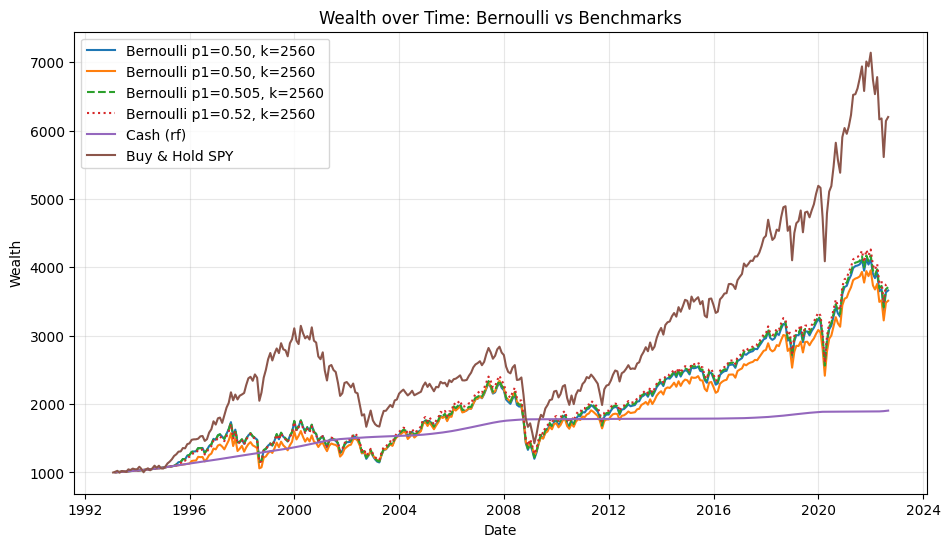

In [76]:
plt.figure(figsize=(11, 6))

plt.plot(
    res_bern_05["wealth"]["Month_hold"],
    res_bern_05["wealth"]["wealth"],
    label="Bernoulli p1=0.50, k=2560"
)

plt.plot(
    res_bern_054["wealth"]["Month_hold"],
    res_bern_054["wealth"]["wealth"],
    label="Bernoulli p1=0.50, k=2560"
)

plt.plot(
    res_bern_0505["wealth"]["Month_hold"],
    res_bern_0505["wealth"]["wealth"],
    label="Bernoulli p1=0.505, k=2560",
    linestyle="--"
)

plt.plot(
    res_bern_052["wealth"]["Month_hold"],
    res_bern_052["wealth"]["wealth"],
    label="Bernoulli p1=0.52, k=2560",
    linestyle=":")

plt.plot(
    res_cash["wealth"]["Month_hold"],
    res_cash["wealth"]["wealth"],
    label="Cash (rf)"
)

plt.plot(
    res_spy["Month"],
    res_spy["wealth"],
    label="Buy & Hold SPY"
)

plt.title("Wealth over Time: Bernoulli vs Benchmarks")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [77]:
def summarize_policy(res):
    w = res["wealth"]
    return {
        "final_wealth": w["wealth"].iloc[-1],
        "mean_W_etf": w["W_etf"].mean(),
        "mean_turnover": w["turnover"].mean(),
        "mean_top5_share": w["top5_share"].mean(),
        "mean_n_bet": w["n_bet"].mean(),
    }

summary_df = pd.DataFrame.from_dict({
    "Bernoulli p1=0.50": summarize_policy(res_bern_05),
    "Bernoulli p1=0.505": summarize_policy(res_bern_0505),
    "Bernoulli p1=0.52": summarize_policy(res_bern_052),
    "Bernoulli p1=0.54": summarize_policy(res_bern_054),
    "Cash (rf)": {
        "final_wealth": res_cash["wealth"]["wealth"].iloc[-1],
        "mean_W_etf": 0.0,
        "mean_turnover": 0.0,
        "mean_top5_share": 0.0,
        "mean_n_bet": 0.0,
    },
    "Buy & Hold SPY": {
        "final_wealth": res_spy["wealth"].iloc[-1],
        "mean_W_etf": 1.0,
        "mean_turnover": np.nan,
        "mean_top5_share": 1.0,
        "mean_n_bet": 1,
    }
}, orient="index")

summary_df

,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
Bernoulli p1=0.50,3662.550352,0.911606,0.077515,0.265682,170.616901
Bernoulli p1=0.505,3709.613727,0.910506,0.080486,0.272699,167.087324
Bernoulli p1=0.52,3783.681081,0.902773,0.091343,0.294252,152.222535
Bernoulli p1=0.54,3511.412305,0.876079,0.105519,0.314676,129.811268
Cash (rf),1904.366630,0.000000,0.000000,0.000000,0.000000
Buy & Hold SPY,6199.512238,1.000000,NaN,1.000000,1.000000


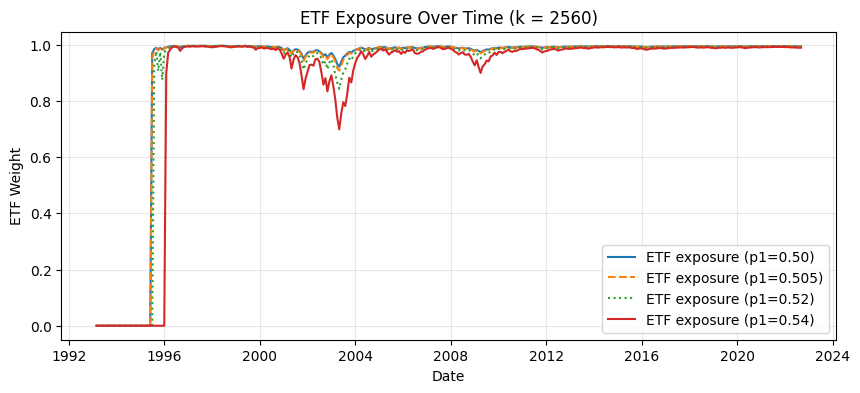

In [78]:
plt.figure(figsize=(10, 4))
plt.plot(
    res_bern_05["wealth"]["Month_hold"],
    res_bern_05["wealth"]["W_etf"],
    label="ETF exposure (p1=0.50)"
)
plt.plot(
    res_bern_0505["wealth"]["Month_hold"],
    res_bern_0505["wealth"]["W_etf"],
    label="ETF exposure (p1=0.505)",
    linestyle="--"
)
plt.plot(
    res_bern_052["wealth"]["Month_hold"],
    res_bern_052["wealth"]["W_etf"],
    label="ETF exposure (p1=0.52)",
    linestyle=":"
)
plt.plot(
    res_bern_054["wealth"]["Month_hold"],
    res_bern_054["wealth"]["W_etf"],
    label="ETF exposure (p1=0.54)",
    linestyle="-"
)
plt.title("ETF Exposure Over Time (k = 2560)")
plt.ylabel("ETF Weight")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Run Student-t Simulation

In [82]:
# POLICY SIMULATION — STUDENT-t VERSION

def run_policy_simulation_studentt(df, k, initial_wealth=1000.0):
    """
    Student-t policy simulation.
    - Beliefs: used only for birth prior mean
    - States: posterior over mu_i updated with excess_return
    - Scores: E[max(X,0)] with X = mu_i + s_t * T_nu
    - Wealth: uses Growth + rf_month
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    belief_state = init_belief_state_studentt()
    states = init_states_studentt()

    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        # --- learning at decision month t ---
        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt(states, belief_state, df_t)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt(states, df_t, s_t)

        # --- scoring at decision month t ---
        scores = scores_studentt(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng)

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        # --- policy: weights for t+1 ---
        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        # --- apply returns in holding month ---
        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth = wealth * (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    wealth_df = pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS)
    weights_df = pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS)
    scores_df = pd.DataFrame(scores_log, columns=SCORES_LOG_COLS)
    return {"wealth": wealth_df, "weights": weights_df, "scores": scores_df}

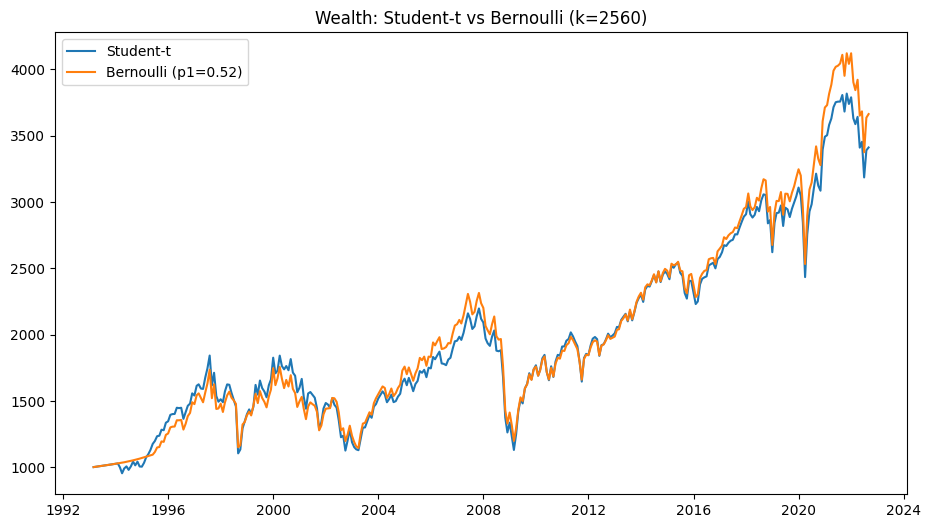

,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
Student-t,3410.844417,0.949690,0.028902,0.207554,207.261972
Bernoulli,3662.550352,0.911606,0.077515,0.265682,170.616901


In [106]:
k_star = 2560

res_t = run_policy_simulation_studentt(df, k=k_star, initial_wealth=1000.0)
res_b = run_policy_simulation_bernoulli(df, p1=0.5, k=k_star, initial_wealth=1000.0)

plt.figure(figsize=(11,6))
plt.plot(res_t["wealth"]["Month_hold"], res_t["wealth"]["wealth"], label="Student-t")
plt.plot(res_b["wealth"]["Month_hold"], res_b["wealth"]["wealth"], label="Bernoulli (p1=0.52)")
plt.legend()
plt.title(f"Wealth: Student-t vs Bernoulli (k={k_star})")
plt.show()

pd.DataFrame({
    "Student-t": {
        "final_wealth": res_t["wealth"]["wealth"].iloc[-1],
        "mean_W_etf": res_t["wealth"]["W_etf"].mean(),
        "mean_turnover": res_t["wealth"]["turnover"].mean(),
        "mean_top5_share": res_t["wealth"]["top5_share"].mean(),
        "mean_n_bet": res_t["wealth"]["n_bet"].mean(),
    },
    "Bernoulli": {
        "final_wealth": res_b["wealth"]["wealth"].iloc[-1],
        "mean_W_etf": res_b["wealth"]["W_etf"].mean(),
        "mean_turnover": res_b["wealth"]["turnover"].mean(),
        "mean_top5_share": res_b["wealth"]["top5_share"].mean(),
        "mean_n_bet": res_b["wealth"]["n_bet"].mean(),
    }
}).T

## We suspect that student-t is not adjusting enough for risk and overweighting high volatility ETFs due to fat tails in the scoring function, we create a new risk adjusted scoring function

In [87]:
def scores_studentt_v2(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    V2: risk-adjusted upside score
      score = E[max(X,0)] / s_t
    where X = mu_i + s_t * T_nu
    """
    scores = {}
    if (not np.isfinite(s_t)) or s_t <= 0:
        return {etf: 0.0 for etf in A_t}

    t_draws = spst.t.rvs(df=nu, size=mc_N, random_state=rng).astype(float)
    denom = float(max(s_t, 1e-12))

    for etf in A_t:
        st = states.get(etf, None)
        if st is None:
            scores[etf] = 0.0
            continue

        mu = float(st["m"])
        X = mu + float(s_t) * t_draws
        upside = float(np.mean(np.maximum(X, 0.0)))
        score = upside / denom

        scores[etf] = max(0.0, max(score, float(eps_s)) if score > 0 else 0.0)

    return scores

In [88]:
def run_policy_simulation_studentt_v2(df, k, initial_wealth=1000.0):
    """
    Student-t simulation V2:
    Same as run_policy_simulation_studentt (V1), but uses scores_studentt_v2.
    Nothing in V1 is modified.
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    belief_state = init_belief_state_studentt()
    states = init_states_studentt()

    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        # learning at decision month t
        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt(states, belief_state, df_t)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt(states, df_t, s_t)

        # scoring V2
        scores = scores_studentt_v2(states, A_t, s_t, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng)

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        # policy: weights for t+1
        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        # apply returns in holding month
        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth *= (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    return {
        "wealth": pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS),
        "weights": pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS),
        "scores": pd.DataFrame(scores_log, columns=SCORES_LOG_COLS),
    }

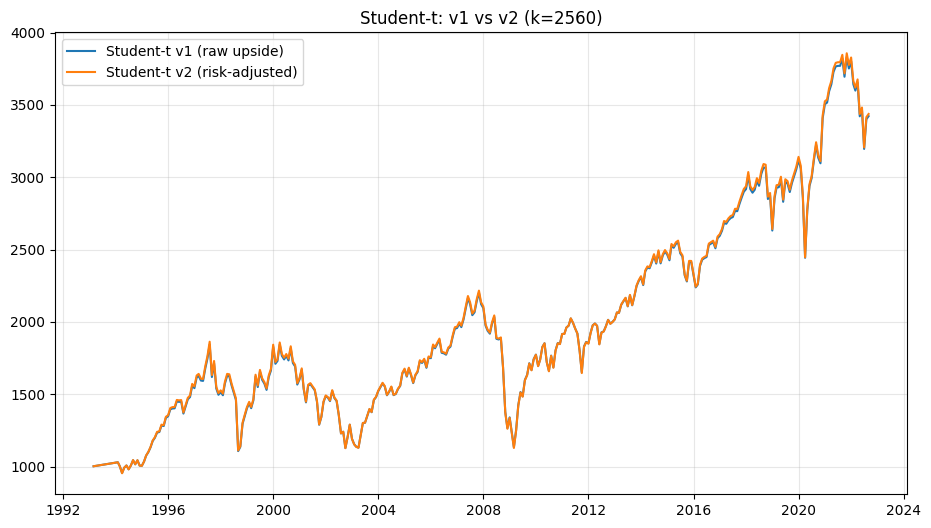

,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
Student-t v1,3422.419542,0.949674,0.029063,0.207594,207.261972
Student-t v2,3437.454125,0.965424,0.028781,0.211487,207.261972


In [89]:
k_star = 2560

res_t_v1 = run_policy_simulation_studentt(df, k=k_star, initial_wealth=1000.0)      # your original
res_t_v2 = run_policy_simulation_studentt_v2(df, k=k_star, initial_wealth=1000.0)   # new

plt.figure(figsize=(11,6))
plt.plot(res_t_v1["wealth"]["Month_hold"], res_t_v1["wealth"]["wealth"], label="Student-t v1 (raw upside)")
plt.plot(res_t_v2["wealth"]["Month_hold"], res_t_v2["wealth"]["wealth"], label="Student-t v2 (risk-adjusted)")
plt.legend()
plt.title(f"Student-t: v1 vs v2 (k={k_star})")
plt.grid(alpha=0.3)
plt.show()

def summarize_policy(res):
    w = res["wealth"]
    return {
        "final_wealth": w["wealth"].iloc[-1],
        "mean_W_etf": w["W_etf"].mean(),
        "mean_turnover": w["turnover"].mean(),
        "mean_top5_share": w["top5_share"].mean(),
        "mean_n_bet": w["n_bet"].mean(),
    }

pd.DataFrame({
    "Student-t v1": summarize_policy(res_t_v1),
    "Student-t v2": summarize_policy(res_t_v2),
}).T

In [90]:
k_grid_studentt = [1, 2, 5, 10, 25, 50, 100, 200, 400, 800, 1600, 2560]

rows = []
res_studentt_v2_grid = {}

for k in k_grid_studentt:
    print(f"Student-t v2 run: k={k}")
    res = run_policy_simulation_studentt_v2(df, k=k, initial_wealth=1000.0)
    res_studentt_v2_grid[k] = res

    w = res["wealth"]
    rows.append({
        "k": float(k),
        "final_wealth": float(w["wealth"].iloc[-1]),
        "mean_W_etf": float(w["W_etf"].mean()),
        "mean_turnover": float(w["turnover"].mean()),
        "mean_top5_share": float(w["top5_share"].mean()),
        "mean_n_bet": float(w["n_bet"].mean()),
    })

summary_studentt_v2 = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
summary_studentt_v2

Student-t v2 run: k=1
Student-t v2 run: k=2
Student-t v2 run: k=5
Student-t v2 run: k=10
Student-t v2 run: k=25
Student-t v2 run: k=50
Student-t v2 run: k=100
Student-t v2 run: k=200
Student-t v2 run: k=400
Student-t v2 run: k=800
Student-t v2 run: k=1600
Student-t v2 run: k=2560


,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,1.0,2414.932023,0.318758,0.019609,0.073752,207.261972
1,2.0,2705.489237,0.479543,0.024985,0.109303,207.261972
2,5.0,3026.475596,0.686632,0.028978,0.153493,207.261972
3,10.0,3237.108408,0.801905,0.029155,0.177677,207.261972
4,25.0,3355.368381,0.893261,0.029077,0.196500,207.261972
5,50.0,3403.445176,0.928237,0.028847,0.203877,207.261972
6,100.0,3407.817817,0.946781,0.028790,0.207596,207.261972
7,200.0,3437.143765,0.956436,0.028729,0.209548,207.261972
8,400.0,3435.752348,0.961270,0.028754,0.210588,207.261972
9,800.0,3439.167527,0.963729,0.028787,0.211054,207.261972


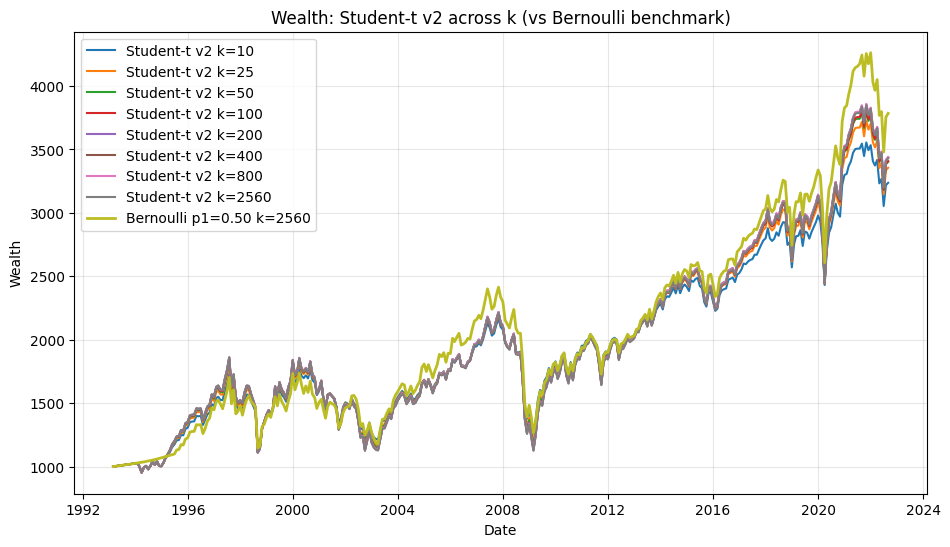

In [91]:
# Bernoulli saturated benchmark
res_bern_bench = run_policy_simulation_bernoulli(df, p1=0.52, k=2560, initial_wealth=1000.0)
wB = res_bern_bench["wealth"]

bench_row = pd.DataFrame([{
    "k": 2560.0,
    "final_wealth": float(wB["wealth"].iloc[-1]),
    "mean_W_etf": float(wB["W_etf"].mean()),
    "mean_turnover": float(wB["turnover"].mean()),
    "mean_top5_share": float(wB["top5_share"].mean()),
    "mean_n_bet": float(wB["n_bet"].mean()),
}], index=["Bernoulli p1=0.52, k=2560"])

bench_row

k_plot = [10, 25, 50, 100, 200, 400, 800, 2560]

plt.figure(figsize=(11,6))
for k in k_plot:
    res = res_studentt_v2_grid[k]
    plt.plot(res["wealth"]["Month_hold"], res["wealth"]["wealth"], label=f"Student-t v2 k={k}")

plt.plot(wB["Month_hold"], wB["wealth"], label="Bernoulli p1=0.52 k=2560", linewidth=2)

plt.title("Wealth: Student-t v2 across k (vs Bernoulli benchmark)")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## We notice that student-t performance is quite flat relative to k and peaks at 800-1600, it still has high mean number of ETFs we will now do a top N method with risk adjustment

In [92]:
def scores_studentt_v3_topN(states, A_t, s_t, N=50, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    Student-t score V3:
      1) compute risk-adjusted scores via V2
      2) keep only Top-N ETFs by score (others set to 0)
    """
    base_scores = scores_studentt_v2(
        states, A_t, s_t,
        nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
    )

    # sort ETFs by score descending
    ranked = sorted(base_scores.items(), key=lambda kv: kv[1], reverse=True)

    # keep only positive-score ETFs, then top N among them
    ranked_pos = [(etf, s) for etf, s in ranked if s > 0.0]
    keep = set(etf for etf, _ in ranked_pos[:int(N)])

    # zero out everyone else
    scores = {etf: (base_scores[etf] if etf in keep else 0.0) for etf in A_t}
    return scores


In [93]:
def run_policy_simulation_studentt_v3_topN(df, k, N=50, initial_wealth=1000.0):
    """
    Student-t simulation V3:
    Same as V1/V2 backbone, but scoring is:
      scores_studentt_v3_topN(..., N)
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    belief_state = init_belief_state_studentt()
    states = init_states_studentt()

    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        # learning at decision month t
        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt(states, belief_state, df_t)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt(states, df_t, s_t)

        # scoring V3 (Top-N)
        scores = scores_studentt_v3_topN(
            states, A_t, s_t,
            N=N, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
        )

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        # policy: weights for t+1
        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        # apply returns in holding month
        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth *= (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    return {
        "wealth": pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS),
        "weights": pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS),
        "scores": pd.DataFrame(scores_log, columns=SCORES_LOG_COLS),
    }

In [96]:
k_grid = [25, 100, 200, 800]
N_grid = [5, 10, 20, 50, 100]

rows = []

for N in N_grid:
    for k in k_grid:
        print(f"Student-t v3 TopN run: N={N}, k={k}")
        res = run_policy_simulation_studentt_v3_topN(df, k=k, N=N, initial_wealth=1000.0)
        w = res["wealth"]
        rows.append({
            "N": int(N),
            "k": float(k),
            "final_wealth": float(w["wealth"].iloc[-1]),
            "mean_W_etf": float(w["W_etf"].mean()),
            "mean_turnover": float(w["turnover"].mean()),
            "mean_top5_share": float(w["top5_share"].mean()),
            "mean_n_bet": float(w["n_bet"].mean()),
        })

summary_topN = pd.DataFrame(rows).sort_values(["N","k"]).reset_index(drop=True)
summary_topN

Student-t v3 TopN run: N=5, k=25
Student-t v3 TopN run: N=5, k=100
Student-t v3 TopN run: N=5, k=200
Student-t v3 TopN run: N=5, k=800
Student-t v3 TopN run: N=10, k=25
Student-t v3 TopN run: N=10, k=100
Student-t v3 TopN run: N=10, k=200
Student-t v3 TopN run: N=10, k=800
Student-t v3 TopN run: N=20, k=25
Student-t v3 TopN run: N=20, k=100
Student-t v3 TopN run: N=20, k=200
Student-t v3 TopN run: N=20, k=800
Student-t v3 TopN run: N=50, k=25
Student-t v3 TopN run: N=50, k=100
Student-t v3 TopN run: N=50, k=200
Student-t v3 TopN run: N=50, k=800
Student-t v3 TopN run: N=100, k=25
Student-t v3 TopN run: N=100, k=100
Student-t v3 TopN run: N=100, k=200
Student-t v3 TopN run: N=100, k=800


,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,5,25.0,2997.142703,0.447554,0.088711,0.447554,4.538028
1,5,100.0,3681.227108,0.681031,0.142322,0.681031,4.538028
2,5,200.0,3879.429615,0.780374,0.165080,0.780374,4.538028
3,5,800.0,4206.279423,0.904333,0.190937,0.904333,4.538028
4,10,25.0,3306.265859,0.548116,0.091901,0.352426,8.661972
5,10,100.0,4273.238670,0.770084,0.133261,0.474970,8.661972
6,10,200.0,4679.449831,0.848787,0.147135,0.517661,8.661972
7,10,800.0,5150.858618,0.931140,0.160730,0.562220,8.661972
8,20,25.0,3409.104921,0.648851,0.085015,0.288317,16.414085
9,20,100.0,4093.323893,0.840399,0.111594,0.349102,16.414085


## TopN but non-risk adjusted

In [101]:
def scores_studentt_v4_topN_v1(states, A_t, s_t, N=50, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng):
    """
    Student-t score V4:
      1) compute base scores using V1 (raw upside) = E[max(X,0)]
      2) keep only Top-N ETFs by score (others set to 0)
    """
    base_scores = scores_studentt(
        states, A_t, s_t,
        nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
    )

    ranked = sorted(base_scores.items(), key=lambda kv: kv[1], reverse=True)
    ranked_pos = [(etf, s) for etf, s in ranked if s > 0.0]
    keep = set(etf for etf, _ in ranked_pos[:int(N)])

    scores = {etf: (base_scores[etf] if etf in keep else 0.0) for etf in A_t}
    return scores


In [98]:
def run_policy_simulation_studentt_v4_topN_v1(df, k, N=50, initial_wealth=1000.0):
    """
    Student-t simulation V4:
    Same backbone, but scoring is:
      scores_studentt_v4_topN_v1(..., N)
    """
    months = sorted(df[MONTH_COL].unique())
    wealth = float(initial_wealth)

    wealth_log = []
    weights_log = []
    scores_log = []

    belief_state = init_belief_state_studentt()
    states = init_states_studentt()

    prev_weights_full = {"CASH": 1.0}

    for t_idx in range(len(months) - 1):
        month_t = months[t_idx]
        month_hold = months[t_idx + 1]

        df_t = df[df[MONTH_COL] == month_t]
        df_hold = df[df[MONTH_COL] == month_hold]
        A_t = df_t[ETF_COL].unique().tolist()

        update_beliefs_studentt(belief_state, df_t)
        ensure_states_studentt(states, belief_state, df_t)

        s_t = global_volatility(df, month_t, vol_window=vol_window)
        update_states_studentt(states, df_t, s_t)

        scores = scores_studentt_v4_topN_v1(
            states, A_t, s_t,
            N=N, nu=nu, mc_N=mc_N, eps_s=eps_s, rng=rng
        )

        for etf, s in scores.items():
            scores_log.append({"Month_decide": month_t, "ETF": etf, "score": s})

        w_etf, w_cash, diag = scores_to_weights(scores, k)

        for etf, w in w_etf.items():
            weights_log.append({"Month_hold": month_hold, "ETF": etf, "weight": w})
        weights_log.append({"Month_hold": month_hold, "ETF": "CASH", "weight": w_cash})

        port_ret = portfolio_return_for_month(df_hold, w_etf, w_cash)
        wealth *= (1.0 + port_ret)

        curr_weights_full = {**w_etf, "CASH": w_cash}
        turn = turnover(prev_weights_full, curr_weights_full)
        prev_weights_full = curr_weights_full

        wealth_log.append({
            "Month_hold": month_hold,
            "port_ret": port_ret,
            "wealth": wealth,
            "w_cash": w_cash,
            "W_etf": 1.0 - w_cash,
            "mean_score": diag["mean_score"],
            "turnover": turn,
            "n_bet": diag["n_pos_scores"],
            "top5_share": diag["top5_share"],
        })

    return {
        "wealth": pd.DataFrame(wealth_log, columns=WEALTH_LOG_COLS),
        "weights": pd.DataFrame(weights_log, columns=WEIGHTS_LOG_COLS),
        "scores": pd.DataFrame(scores_log, columns=SCORES_LOG_COLS),
    }

In [103]:
k_grid = [100, 200, 800]
N_grid = [5, 10, 20, 50]

rows_train = []

for N in N_grid:
    for k in k_grid:
        # V3: TopN + v2 score
        res3 = run_policy_simulation_studentt_v3_topN(df_train, k=k, N=N, initial_wealth=1000.0)
        w3 = res3["wealth"]
        rows_train.append({
            "variant": "TopN_v2score",
            "N": int(N),
            "k": float(k),
            "final_wealth": float(w3["wealth"].iloc[-1]),
            "mean_W_etf": float(w3["W_etf"].mean()),
            "mean_turnover": float(w3["turnover"].mean()),
            "mean_top5_share": float(w3["top5_share"].mean()),
            "mean_n_bet": float(w3["n_bet"].mean()),
        })

        # V4: TopN + v1 score
        res4 = run_policy_simulation_studentt_v4_topN_v1(df_train, k=k, N=N, initial_wealth=1000.0)
        w4 = res4["wealth"]
        rows_train.append({
            "variant": "TopN_v1score",
            "N": int(N),
            "k": float(k),
            "final_wealth": float(w4["wealth"].iloc[-1]),
            "mean_W_etf": float(w4["W_etf"].mean()),
            "mean_turnover": float(w4["turnover"].mean()),
            "mean_top5_share": float(w4["top5_share"].mean()),
            "mean_n_bet": float(w4["n_bet"].mean()),
        })

summary_topN_train = pd.DataFrame(rows_train).sort_values(["variant","N","k"]).reset_index(drop=True)
summary_topN_train

,variant,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,TopN_v1score,5,100.0,2202.860155,0.293006,0.053416,0.293006,4.376426
1,TopN_v1score,5,200.0,2413.543983,0.399282,0.070818,0.399282,4.376426
2,TopN_v1score,5,800.0,2962.100452,0.629493,0.116035,0.629493,4.376426
3,TopN_v1score,10,100.0,2190.758593,0.364744,0.056160,0.248880,8.193916
4,TopN_v1score,10,200.0,2478.148837,0.486036,0.073859,0.325301,8.193916
5,TopN_v1score,10,800.0,3055.783834,0.719062,0.110616,0.463309,8.193916
6,TopN_v1score,20,100.0,2239.179915,0.444508,0.054830,0.223514,15.159696
7,TopN_v1score,20,200.0,2470.170639,0.575922,0.068778,0.280376,15.159696
8,TopN_v1score,20,800.0,2869.457413,0.793374,0.093077,0.364939,15.159696
9,TopN_v1score,50,100.0,2150.016158,0.554573,0.049112,0.203098,34.250951


In [104]:
best_per_variant = (
    summary_topN_train
    .sort_values(["variant","final_wealth","mean_turnover"], ascending=[True, False, True])
    .groupby("variant", as_index=False)
    .head(1)
)

best_per_variant

,variant,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
5,TopN_v1score,10,800.0,3055.783834,0.719062,0.110616,0.463309,8.193916
17,TopN_v2score,10,800.0,3642.469324,0.935783,0.147559,0.585588,8.193916


In [105]:
rows_test = []

for _, row in best_per_variant.iterrows():
    variant = row["variant"]
    N = int(row["N"])
    k = float(row["k"])

    if variant == "TopN_v2score":
        res = run_policy_simulation_studentt_v3_topN(df_test, k=k, N=N, initial_wealth=1000.0)
    else:
        res = run_policy_simulation_studentt_v4_topN_v1(df_test, k=k, N=N, initial_wealth=1000.0)

    w = res["wealth"]
    rows_test.append({
        "variant": variant,
        "N": N,
        "k": k,
        "final_wealth": float(w["wealth"].iloc[-1]),
        "mean_W_etf": float(w["W_etf"].mean()),
        "mean_turnover": float(w["turnover"].mean()),
        "mean_top5_share": float(w["top5_share"].mean()),
        "mean_n_bet": float(w["n_bet"].mean()),
    })

summary_topN_test = pd.DataFrame(rows_test).sort_values("final_wealth", ascending=False).reset_index(drop=True)
summary_topN_test

,variant,N,k,final_wealth,mean_W_etf,mean_turnover,mean_top5_share,mean_n_bet
0,TopN_v2score,10,800.0,1536.583964,0.798566,0.166703,0.425603,8.681319
1,TopN_v1score,10,800.0,1342.656867,0.311616,0.077186,0.166995,8.681319


## Final Comparisons

In [107]:
initial_wealth = 1000.0

# Student-t optimized (from TRAIN)
N_star = 10
k_studentt = 800

# Bernoulli benchmark
p1_bern = 0.50
k_bern = 2560

# RUN STRATEGIES (TEST)
res_studentt = run_policy_simulation_studentt_v3_topN(
    df_test, k=k_studentt, N=N_star, initial_wealth=initial_wealth
)

res_bern = run_policy_simulation_bernoulli(
    df_test, p1=p1_bern, k=k_bern, initial_wealth=initial_wealth
)

res_cash = run_policy_simulation_bernoulli(
    df_test, p1=0.99, k=0.0, initial_wealth=initial_wealth
)

# Buy & Hold SPY
res_spy = run_buy_hold_spy(df_test, initial_wealth)

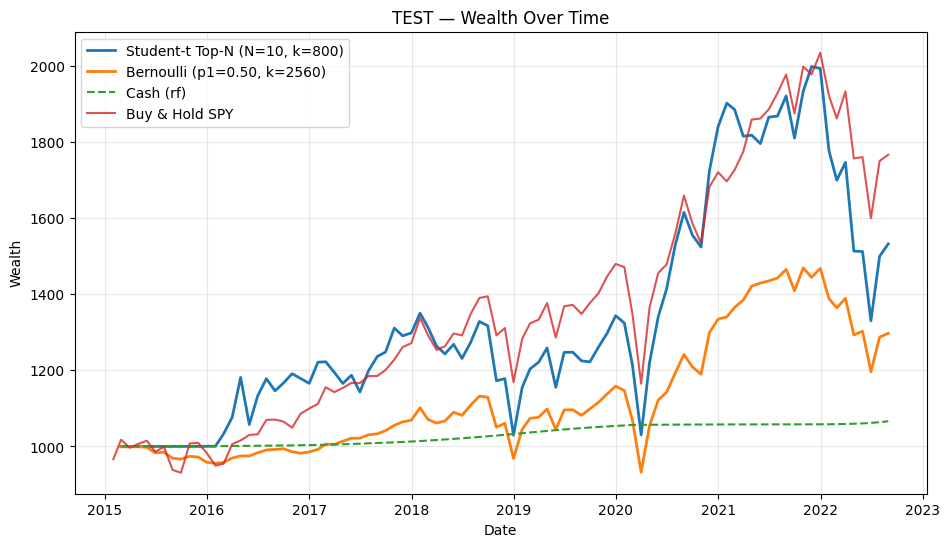

In [108]:
plt.figure(figsize=(11,6))

plt.plot(res_studentt["wealth"]["Month_hold"],
         res_studentt["wealth"]["wealth"],
         label="Student-t Top-N (N=10, k=800)", linewidth=2)

plt.plot(res_bern["wealth"]["Month_hold"],
         res_bern["wealth"]["wealth"],
         label="Bernoulli (p1=0.50, k=2560)", linewidth=2)

plt.plot(res_cash["wealth"]["Month_hold"],
         res_cash["wealth"]["wealth"],
         label="Cash (rf)", linestyle="--")

plt.plot(res_spy["Month"],
         res_spy["wealth"],
         label="Buy & Hold SPY", alpha=0.8)

plt.title("TEST — Wealth Over Time")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

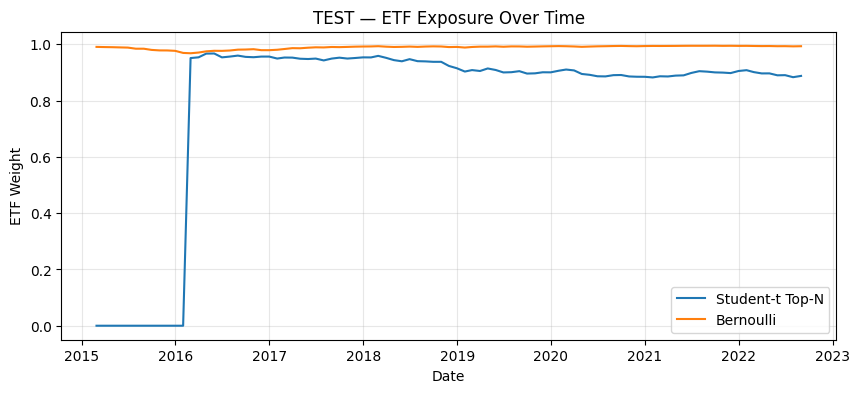

In [109]:
plt.figure(figsize=(10,4))

plt.plot(res_studentt["wealth"]["Month_hold"],
         res_studentt["wealth"]["W_etf"],
         label="Student-t Top-N")

plt.plot(res_bern["wealth"]["Month_hold"],
         res_bern["wealth"]["W_etf"],
         label="Bernoulli")

plt.title("TEST — ETF Exposure Over Time")
plt.ylabel("ETF Weight")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

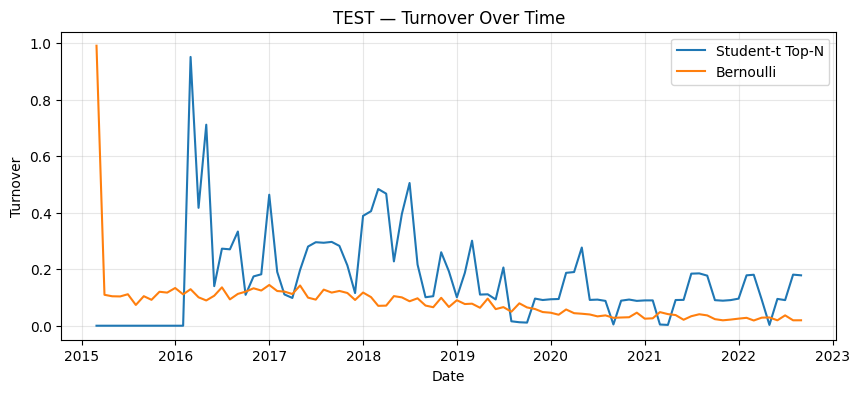

In [110]:
plt.figure(figsize=(10,4))

plt.plot(res_studentt["wealth"]["Month_hold"],
         res_studentt["wealth"]["turnover"],
         label="Student-t Top-N")

plt.plot(res_bern["wealth"]["Month_hold"],
         res_bern["wealth"]["turnover"],
         label="Bernoulli")

plt.title("TEST — Turnover Over Time")
plt.ylabel("Turnover")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [111]:
def summarize_policy(res):
    w = res["wealth"]
    return {
        "final_wealth": float(w["wealth"].iloc[-1]),
        "mean_W_etf": float(w["W_etf"].mean()),
        "mean_turnover": float(w["turnover"].mean()),
        "mean_top5_share": float(w["top5_share"].mean()),
    }

summary_df = pd.DataFrame.from_dict({
    "Student-t Top-N (N=10, k=800)": summarize_policy(res_studentt),
    "Bernoulli (p1=0.50, k=2560)": summarize_policy(res_bern),
    "Cash": {
        "final_wealth": res_cash["wealth"]["wealth"].iloc[-1],
        "mean_W_etf": 0.0,
        "mean_turnover": 0.0,
        "mean_top5_share": 0.0,
    },
    "Buy & Hold SPY": {
        "final_wealth": res_spy["wealth"].iloc[-1],
        "mean_W_etf": 1.0,
        "mean_turnover": np.nan,
        "mean_top5_share": 1.0,
    }
}, orient="index")

summary_df

,final_wealth,mean_W_etf,mean_turnover,mean_top5_share
"Student-t Top-N (N=10, k=800)",1532.179276,0.798447,0.16644,0.425551
"Bernoulli (p1=0.50, k=2560)",1297.062322,0.988911,0.08433,0.081230
Cash,1066.137092,0.000000,0.00000,0.000000
Buy & Hold SPY,1766.077236,1.000000,NaN,1.000000


In [113]:
# simulating on whole dataset

initial_wealth = 1000.0

# Student-t optimized
res_studentt_full = run_policy_simulation_studentt_v3_topN(
    df, k=800, N=10, initial_wealth=initial_wealth
)

# Bernoulli benchmark
res_bern_full = run_policy_simulation_bernoulli(
    df, p1=0.50, k=2560, initial_wealth=initial_wealth
)

# Cash
res_cash_full = run_policy_simulation_bernoulli(
    df, p1=0.99, k=0.0, initial_wealth=initial_wealth
)

# Buy & Hold SPY
res_spy_full = run_buy_hold_spy(df, initial_wealth)

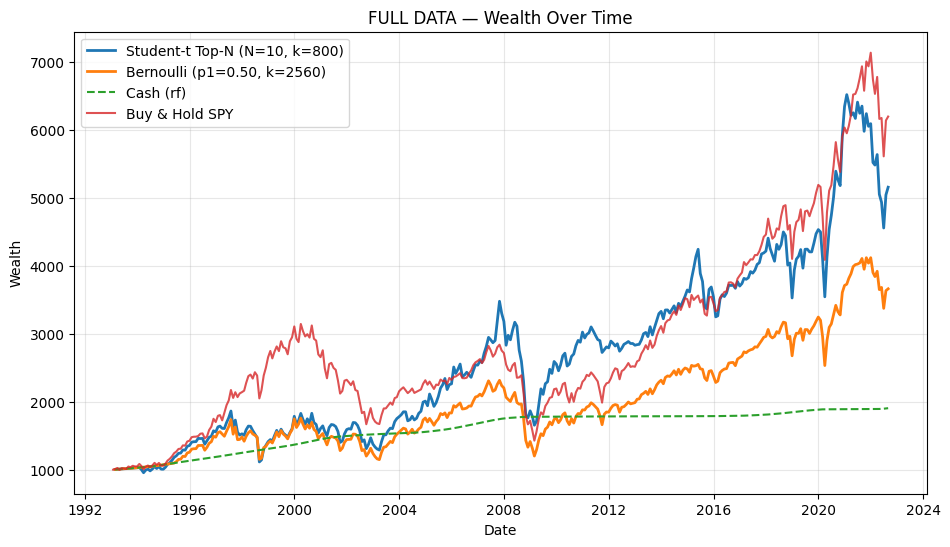

In [114]:
plt.figure(figsize=(11,6))

plt.plot(res_studentt_full["wealth"]["Month_hold"],
         res_studentt_full["wealth"]["wealth"],
         label="Student-t Top-N (N=10, k=800)", linewidth=2)

plt.plot(res_bern_full["wealth"]["Month_hold"],
         res_bern_full["wealth"]["wealth"],
         label="Bernoulli (p1=0.50, k=2560)", linewidth=2)

plt.plot(res_cash_full["wealth"]["Month_hold"],
         res_cash_full["wealth"]["wealth"],
         label="Cash (rf)", linestyle="--")

plt.plot(res_spy_full["Month"],
         res_spy_full["wealth"],
         label="Buy & Hold SPY", alpha=0.8)

plt.title("FULL DATA — Wealth Over Time")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [115]:
def etf_holding_counts(weights_df):
    """
    Count number of months each ETF had non-zero weight.
    """
    df_pos = weights_df.copy()
    df_pos = df_pos[(df_pos["ETF"] != "CASH") & (df_pos["weight"] > 0)]
    counts = (
        df_pos.groupby("ETF")["Month_hold"]
        .nunique()
        .sort_values(ascending=False)
    )
    return counts

In [121]:
bern_counts = etf_holding_counts(res_bern_full["weights"])
studentt_counts = etf_holding_counts(res_studentt_full["weights"])

top_compare = pd.DataFrame({
    "Bernoulli_months_held": bern_counts,
    "StudentT_months_held": studentt_counts
}).fillna(0).astype(int)

top_compare.sort_values(
    ["StudentT_months_held", "Bernoulli_months_held"],
    ascending=False
).head(10)

,Bernoulli_months_held,StudentT_months_held
ETF,,
EWW,317,178
SPY,327,123
XAR,130,114
PSCH,146,101
XLE,208,81
QLD,191,81
EWC,305,77
EWD,317,61
JHMT,83,61


In [122]:
top_studentt = (
    top_compare
    .sort_values("StudentT_months_held", ascending=False)
    .head(10)
)

top_studentt

,Bernoulli_months_held,StudentT_months_held
ETF,,
EWW,317,178
SPY,327,123
XAR,130,114
PSCH,146,101
XLE,208,81
QLD,191,81
EWC,305,77
EWD,317,61
JHMT,83,61


In [123]:
top_bern = (
    top_compare
    .sort_values("Bernoulli_months_held", ascending=False)
    .head(10)
)

top_bern

,Bernoulli_months_held,StudentT_months_held
ETF,,
SPY,327,123
EWW,317,178
EWD,317,61
EWC,305,77
EWL,304,33
DIA,295,26
XLV,274,20
IJJ,263,52
IJR,263,28
